# Experiments with Bluetooth Low Energy Beacon Signals

## Imports

In [31]:
# Enable inline Matplotlib
%matplotlib inline

## Imports ##
# JSON
import json

# NumPy
import numpy as np

# Pandas
import pandas as pd
pd.plotting.register_matplotlib_converters()
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 200)

# Matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# SciPy
from scipy import stats

# seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

# scikit-learn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, NuSVR
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale, minmax_scale, robust_scale, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
import joblib

<Figure size 432x288 with 0 Axes>

## Constants and Helper Functions

In [32]:
# Constant that indicated how long each captured beacon be considered to be present (value in milliseconds).
# This effect can be simulated by a running average window over the collected data.
beacons_inactivity_timer=5000
# Constant that indicates how often the device reports about the surrounding beacons (value in milliseconds). 
# This effect can be simulated by resampling the collected data.  
beacons_refresh_interval=1000

# A function that receives the path to a JSON file containing a data collection run to load that file.
# It also receives a few extra to append to the loaded data which characterize the objective of the loaded data, i.e.:
# - The "target beacons" that we were interested in during the data collection phase.
# - The distance that those target beacons were from the data collection point.
def log_loader(file_path, target_beacons, distance):
    with open(file_path) as json_file:
        log = json.load(json_file)
        log['target_beacons'] = target_beacons
        log['distance'] = distance   
        return log

# This function receives a loaded of logs (see previous function), iterates over them, and unrolls them into a DataFrame.
def convert_logs_to_dataframe(logs):
    # List of per log intermediary DataFrames.
    dfs = []
    # Iterate over each log.
    for log in logs:
        # List of lists that represent a table that will be converted into a DataFrame.
        table = []
        # Iterate over the list of target beacons.
        for beacon in log['target_beacons']:
            # Iterate over the logging sessions contained within a log file.
            for entries in log['sessions'].values():
                # Iterate over the entries of each of those sessions.
                for entry in entries:
                    # Get each of the readings in the the entry.
                    reading = entry['reading']
                    # Check if the reading matches our target iBeacon.
                    if reading['type'] == 'iBeacon' and reading['values'][0] == beacon['uuid']\
                    and reading['values'][1] == beacon['major'] and reading['values'][2] == beacon['minor']:
                        # If so extract all the information into and append as row in the table
                        table.append([log['name'],
                                      pd.to_datetime(log['timestamp'], unit='ms'),
                                      entry['id'],
                                      reading['id'],
                                      reading['type'],
                                      str(reading['values']),
                                      reading['values'][0],
                                      reading['values'][1],
                                      reading['values'][2],
                                      reading['txPower'],
                                      reading['rssi'],
                                      pd.to_datetime(reading['timestamp'], unit='ms'),
                                      reading['avgRssi'],
                                      log['distance']])
        
        # After collection everything of interest in the log file into a plain "list of lists",
        # convert into a DataFrame by specifying the column names
        df = pd.DataFrame(table, columns=['filename',
                                          'creationTimestamp',
                                          'entry',
                                          'id',
                                          'type',
                                          'values',
                                          'uuid',
                                          'major',
                                          'minor',
                                          'txPower',
                                          'rssi',
                                          'timestamp',
                                          'avgRssi',
                                          'distance'])
        # If for some reason there are duplicate timestamps on a log file drop them.
        df.drop_duplicates(subset=['timestamp'], inplace=True)
        # Append the DataFrame to the list of DataFrames.
        dfs.append(df)
    # Return the single DataFrame that results from the concatenation of the individual DataFrames.
    # Also reset the index and select only the relevant columns.
    return pd.concat(dfs, ignore_index=True)[['timestamp','values', 'distance', 'rssi', 'avgRssi']]

# A function that should be applied per each device/distance combo, assuming that this corresponds to one and only one of
# the previously loaded log files.
def per_group(d):
    # Compute the difference between the current and previous sample
    d['timestamp_diff'] = d['timestamp'].diff()
    # Use the inverse of the zscore as the weight for each of the samples
    d['weight'] = 1 / (np.abs(stats.zscore(d['rssi'])) + 1)
    # However, the z-score result can be 0 so 1/0 will result in infinity. We need to replace those values by something else.
    # For now, we simply indentify what is the largest value other than infinity and set all the instances of infinity by
    # a number that is slightly larger than that (1% to be exact).
    d.replace(np.inf, d.loc[d.weight != np.inf, 'weight'].max()*1.01, inplace=True)
    # Calculate a running average over the RSSI values to filter out undesired signal strength fluctuation. 
    # In practive, this type of filtering needs to reach a trade-off between stopping abrupt signal changes and 
    # responsiveness to user moveiment.
    d['rolling_mean_rssi'] = d[['timestamp', 'rssi']].rolling(pd.Timedelta(beacons_inactivity_timer, unit='ms'), on='timestamp')['rssi'].mean()
    # Return the DataFrame slice to be merged with all the others.
    return d

# A function that can be used to resample a dataframe according to a given sample interval.
def resample_group(d, sample_interval=beacons_refresh_interval):
    # Change the index to the timestamp column, resample according to the provided sample interval with the desired options (read pandas documentation for details).
    r = d.set_index('timestamp', verify_integrity=True).resample(pd.Timedelta(sample_interval, unit='ms'), label='right', closed='right').pad()
    # Copy the index column to a new column
    r['timestamp_diff'] = r.index
    # Use that new column to store the difference between each row, thus allowing us to check if the resampling process was sucessfully made as desired.
    r['timestamp_diff'] = r['timestamp_diff'].diff()
    return r

## Load Data

In [33]:
# Load Data
# Generate the list of distances at which we collected samples (i.e., 0 to 10 meters in 0.5 meters intervals)
distances = np.linspace(0,10,21)
# A dictionary that describes our data collection task.
collections = {
    # A laptop
    'laptop': {
        # collected samples at theses distances
        'distances': distances,
        # from the following targets:
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 102 }]
    },
    # # A smartphone
    # 'smartphone':  {
    #     # collected samples at these distances
    #     'distances': distances,
    #     # from the following targets:
    #     'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 101 }]
    # }
}

# Initialize a dictionary that will store the dataframes for each of the devices, indexed by the device name.
tables = {}
# Iterate over the data collection task defined above
for name, device in collections.items():
    # Initialize a list to collect the logs for each of the distances.
    logs = []
    # Iterate over each of the distances collected for the device.
    for d in device['distances']:
        # Load the corresponding file based on the following pattern
        logs.append(log_loader('data/beacons/'+name+'/beacons-'+str(d)+'.json', device['targets'], d))
    # Conver the list of logs to a DataFrame and story in the tables dictionary indexed by the device name.
    tables[name] = convert_logs_to_dataframe(logs)
    # Add a column to the DataFrame which identifies each of each lines as belonging to a certain device.
    tables[name]['device'] = name

# Concatenate the DataFrames for each device into a single DataFrame (recreate the index while at it).
data = pd.concat(tables.values(), ignore_index=True)
# Group the data by Device and Distance, apply the "per_collector_device_distance" function.
# NOTE: This is needed to perform a few extra computations for each of the logging sessions. I could have probably done this
# while loading the data but I decided to keep things separate. However, this may need to be changed if in the future
# grouping turns out not to be enough to slice the data on "per log" basis.
data = data.groupby(['device','distance']).apply(per_group).reset_index(drop=True)

# Just setting some proximity labels based on distance.
# This may be useful if we end up deciding that classification is better than regression for our use case.
# The labels are open to discussion, but these distances are based on Edward T. Hall proxemics theory:
# - https://en.wikipedia.org/wiki/Proxemics#/media/File:Personal_Space.svg
data.loc[data.distance <= 0.4572, 'proximity'] = 'intimate_space'
data.loc[(data['distance'] > 0.4572) & (data['distance'] <= 1.2192), 'proximity'] = 'personal_space'
data.loc[(data['distance'] > 1.2192) & (data['distance'] <= 3.6576), 'proximity'] = 'social_space'
data.loc[(data['distance'] > 3.6576) & (data['distance'] <= 7.62), 'proximity'] = 'public_space'
data.loc[data['distance'] > 7.62, 'proximity'] = 'far_away'

# TODO: 
# Since data is already being saved to CSV/Excel below, perhaps we could check if the files are present before loading 
# data from the JSON logs thus avoiding the repeatition of this loading process each time the notebook is opened.

# Save the DataFrame to a CSV file.
data.to_csv('out/beacons.csv')
# Save the DataFrame to an Excel file
data.to_excel('out/beacons.xlsx')
# Display the DataFrame
data

,timestamp,values,distance,rssi,avgRssi,device,timestamp_diff,weight,rolling_mean_rssi,proximity
0,2019-10-03 12:57:22.098,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-56.000000,laptop,NaT,0.413058,-56.000000,intimate_space
1,2019-10-03 12:57:22.230,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,laptop,0 days 00:00:00.132000,0.511489,-53.000000,intimate_space
2,2019-10-03 12:57:22.515,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,laptop,0 days 00:00:00.285000,0.859800,-52.666667,intimate_space
3,2019-10-03 12:57:22.922,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.750000,laptop,0 days 00:00:00.407000,0.425336,-51.750000,intimate_space
4,2019-10-03 12:57:23.059,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.000000,laptop,0 days 00:00:00.137000,0.811066,-52.000000,intimate_space
5,2019-10-03 12:57:23.199,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.166667,laptop,0 days 00:00:00.140000,0.811066,-52.166667,intimate_space
6,2019-10-03 12:57:23.331,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.714286,laptop,0 days 00:00:00.132000,0.425336,-51.714286,intimate_space
7,2019-10-03 12:57:23.460,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-51.875000,laptop,0 days 00:00:00.129000,0.811066,-51.875000,intimate_space
8,2019-10-03 12:57:23.593,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-54,-52.111111,laptop,0 days 00:00:00.133000,0.613891,-52.111111,intimate_space
9,2019-10-03 12:57:23.721,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-55,-52.400000,laptop,0 days 00:00:00.128000,0.493837,-52.400000,intimate_space


### Plotting Data Distribution with Multiple Scalers

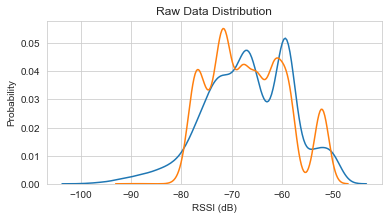

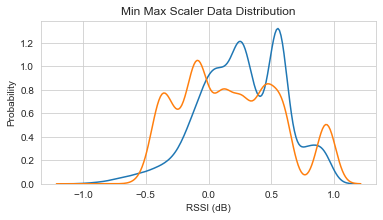

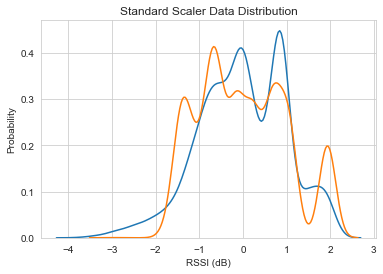

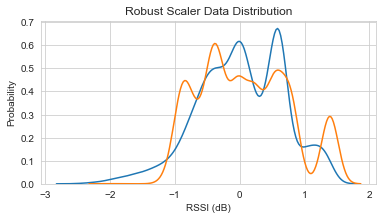

In [34]:
# Just for "debug" purposes we are plotting probability density function (PDF) based on kernel density estimation (KDE) for
# different types of data scaling (raw data, min max scaler between -1 and 1, standard scaler and robust scaler).
# For our data scaling doesn't seem to affect the overall shape of the distributions since they are already related 
# (the Rolling Mean RSSI is derived from the RSSI) and they probably have very similar ranges in the raw data.
# Notwidthstanding, check these examples which my motivation to conduct this little experiment:
# - https://www.kaggle.com/discdiver/guide-to-scaling-and-standardizing
# - https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

# We set the plot size
plt.figure(figsize=(6,3))
# Title
plt.title('Raw Data Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(data['rssi'], label='RSSI');
# The KDE plot for the Rolling Mean RSSI column
sns.kdeplot(data['rolling_mean_rssi'], label='Rolling Mean RSSI');
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

# Now we do it all again but we scale the data with 'minmax_scale' (Min Max Scaler)
# NOTE: I used -1 and 1 as an example here because regression using SVR and some kernel (polynomial) got stuck if I used the
# default which is 0 and 1. It seems that SVM/SVR, and other algorithms, work better when that is centered around 0 thus -1, 1
# gets us close to that.
plt.figure(figsize=(6,3))
plt.title('Min Max Scaler Data Distribution')
# The KDE plot for the RSSI column after scaling it using the 'minmax_scale' to keep everything between -1 and 1.
sns.kdeplot(minmax_scale(data['rssi'], (-1,1)), label='RSSI')
# The KDE plot for the Rolling Mean RSSI column after scaling it using the 'minmax_scale' to keep everything between -1 and 1.
sns.kdeplot(minmax_scale(data['rolling_mean_rssi'], (-1,1)), label='Rolling Mean RSSI');
plt.xlabel('RSSI (dB)')
plt.ylabel('Probability')
plt.show()

# Now we do it all again but we scale the data with 'scale' (Standard Scaler)
plt.figure(figsize=(6,4))
plt.title('Standard Scaler Data Distribution')
# The KDE plot for the RSSI column after scaling it using the standard scaler
sns.kdeplot(scale(data['rssi']), label='RSSI')
# The KDE plot for the Rolling Mean RSSI column after scaling it using the standard scaler
sns.kdeplot(scale(data['rolling_mean_rssi']), label='Rolling Mean RSSI');
plt.xlabel('RSSI (dB)')
plt.ylabel('Probability')
plt.show()

# Now we do it all again but we scale the data with 'robust_scale' (Robust Scaler)
plt.figure(figsize=(6,3))
plt.title('Robust Scaler Data Distribution')
# The KDE plot for the RSSI column after scaling it using the robust scaler
sns.kdeplot(robust_scale(data['rssi']), label='RSSI')
# The KDE plot for the Rolling Mean RSSI column after scaling it using the robust scaler
sns.kdeplot(robust_scale(data['rolling_mean_rssi']), label='Rolling Mean RSSI');
plt.xlabel('RSSI (dB)')
plt.ylabel('Probability')
plt.show()

## Regression

### Prepare Data

In [35]:
# Number of splits for Cross Validation 
n_splits = 3
# Let's use a fixed random state in order to ensure reproducible results.
# But it may be a good idea to change this from time to time to make sure that we are not getting good results due to luck.
random_state = 656

# Initialize the 'data_plot' variable that will point to the whole data.
# Alternatively, we may want to discard outlies based on the zscore.
data_plot = data #[data.rssi_zscore < 3]
# The data filtered by device = 'laptop'
data_plot_laptop = data_plot[data_plot.device == 'laptop']
# The data filtered by device = 'smartphone'
data_plot_smartphone = data_plot[data_plot.device == 'smartphone']

# Get and reshape the training data from the dataframe (we can use either 'rssi' or 'rolling_mean_rssi')
X = data_plot['rolling_mean_rssi'].values.reshape(-1,1)
# Get the corresponding weights that were previously computed in order to use them on Weightled Linear Regression,
# or on any other algorithm that supports weighting.
X_weight = data_plot['weight']
# Get the distance measurements that correspond to the training data.
y = data_plot['distance'].values.reshape(-1,1)
# Also convert the measurements to string labels since Stratified Cross Validation does not work properly with floats.
y_labels = data_plot['distance'].astype(str).values.reshape(-1,1)

# Get and reshape the training data from the dataframe for the laptop device (we can use either 'rssi' or 'rolling_mean_rssi')
X_laptop = data_plot_laptop['rolling_mean_rssi'].values.reshape(-1,1)
# Get the distance measurements that correspond to the laptop training data.
y_laptop = data_plot_laptop['distance'].values.reshape(-1,1)

# Get and reshape the training data from the dataframe for the smartphone device (we can use either 'rssi' or 'rolling_mean_rssi')
X_smartphone = data_plot_smartphone['rolling_mean_rssi'].values.reshape(-1,1)
# Get the distance measurements that correspond to the smartphone training data.
y_smartphone = data_plot_smartphone['distance'].values.reshape(-1,1)

# Get the distance, rssi and rolling_mean_rssi means for each "device and distance" pair.
# For the laptop:
data_plot_laptop_means = data_plot_laptop.groupby(['device','distance'])[['distance','rssi','rolling_mean_rssi']].mean()
# But also for the laptop:
data_plot_smartphone_means = data_plot_smartphone.groupby(['device','distance'])[['distance','rssi','rolling_mean_rssi']].mean()

# The scorers to be computed as part of the grid search cross validation. The ones below are all the ones that are relevant
# when dealing with regression problems.
scorers = {'explained_variance_score': make_scorer(explained_variance_score),
           'max_error': make_scorer(max_error),
           'mean_absolute_error': make_scorer(mean_absolute_error),
           'mean_squared_error': make_scorer(mean_squared_error),
           'r2_score': make_scorer(r2_score)}
# Despite computing a BUNCH of scorers just so I can inspect them later, only one can be selected as the indicator to be used
# when deciding which parameters are better. Since we are currently dealing with regression, the R2 scorer is a common choice.
refit_scorer = 'r2_score'
poly_degree=1

### Linear Regression

In [36]:
# Prepare a pipeline for linear regression
linear_regression_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree)),
    # Second step: the regression algorithm
    ('regression', LinearRegression())
])
# A dictionary of parameters to permutate and test using GridSearchCV
linear_regression_parameters = {}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
linear_regression_grid = GridSearchCV(linear_regression_pipeline, linear_regression_parameters,
                                      cv=StratifiedKFold(n_splits=n_splits,
                                                         shuffle=True,
                                                         random_state=random_state).split(X, y_labels),
                                      scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
linear_regression_grid.fit(X, y);
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(linear_regression_grid.best_estimator_ , 'out/linear_regression_grid.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


['out/linear_regression_grid.joblib']

### Weighted Linear Regression

In [37]:
# Prepare a pipeline for weighted linear regression
weighted_linear_regression_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree)),
    # Second step: the regression algorithm
    ('regression', LinearRegression())
])
# A dictionary of parameters to permutate and test using GridSearchCV
weighted_linear_regression_parameters = {}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
weighted_linear_regression_grid = GridSearchCV(weighted_linear_regression_pipeline, weighted_linear_regression_parameters,
                                               cv=StratifiedKFold(n_splits=n_splits,
                                                                  shuffle=True,
                                                                  random_state=random_state).split(X, y_labels),
                                               scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
weighted_linear_regression_grid.fit(X, y, regression__sample_weight=X_weight)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(weighted_linear_regression_grid.best_estimator_ , 'out/weighted_linear_regression_grid.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


['out/weighted_linear_regression_grid.joblib']

### SVR (Support-vector Machine Regression)

In [38]:
# Prepare a pipeline for SVR
svr_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    # gamma is set to scale as this will be the new sklearn default going forward and I feel that the current default value 
    # doesn't make much sense when working with unidimensional data. More details: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    ('regression', SVR(gamma='scale'))
])
# A dictionary of parameters to permutate and test using GridSearchCV
# For details regarding the paramets see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
svr_parameters = {
    'regression__kernel': [
        #'linear',
        #'poly',
        'rbf', #Default
        #'sigmoid'
    ],
    'regression__gamma': [
        #'auto', #Default
        'scale'
    ],
    'regression__C': [
        0.1, 0.125, 0.25, 0.5, 
        1.0, #Default
        2.0, 4.0, 8.0, 10.0
    ],
    'regression__epsilon': [
        0.01, 0.0125, 0.025, 0.05,
        0.1, #Default
        0.2, 0.4, 0.8, 1.0
    ]
}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
svr_grid = GridSearchCV(svr_pipeline, svr_parameters,
                        cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                        scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
svr_grid.fit(X, y.ravel())
# Print the best parameters found by GridSearchCV
print('SVR Grid Search:', svr_grid.best_params_)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(svr_grid.best_estimator_, 'out/svr_grid.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   22.3s finished


SVR Grid Search: {'regression__C': 8.0, 'regression__epsilon': 0.8, 'regression__gamma': 'scale', 'regression__kernel': 'rbf'}


['out/svr_grid.joblib']

### NuSVR  (Support-vector Machine Regression)

In [39]:
nusvr_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    # gamma is set to scale as this will be the new sklearn default going forward and I feel that the current default value 
    # doesn't make much sense when working with unidimensional data. More details: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    ('regression', NuSVR(gamma='scale'))
])
# A dictionary of parameters to permutate and test using GridSearchCV
# For details regarding the paramets see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
nusvr_parameters = {
    'regression__kernel': [
        #'linear',
        #'poly',
        'rbf', #Default
        #'sigmoid'
    ],
    'regression__nu': [
        0.01, 0.1, 0.25,
        0.5, #Default
        0.75, 0.99, 1.0
    ],
    'regression__C': [
        0.1, 0.125, 0.25, 0.5, 
        1.0, #Default
        2.0, 4.0, 8.0, 10.0
    ],
}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
nusvr_grid = GridSearchCV(nusvr_pipeline, nusvr_parameters,
                          cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                          scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
nusvr_grid.fit(X, y.ravel())
# Print the best parameters found by GridSearchCV
print('NuSVR Grid Search:', nusvr_grid.best_params_)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(nusvr_grid.best_estimator_ , 'out/nusvr_grid.joblib')

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   17.3s finished


NuSVR Grid Search: {'regression__C': 8.0, 'regression__kernel': 'rbf', 'regression__nu': 0.5}


['out/nusvr_grid.joblib']

### KNN Regression (K-Nearest Neighbors Regression)

In [40]:
knnr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', KNeighborsRegressor())
])

knnr_parameters = {
    'regression__n_neighbors': list(range(1,16)),
    'regression__weights': ['uniform', 'distance']
}

knnr_grid = GridSearchCV(knnr_pipeline, knnr_parameters,
                          cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                          scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)

knnr_grid.fit(X, y.ravel())
print('KNN Regression Grid Search:', knnr_grid.best_params_)

joblib.dump(knnr_grid.best_estimator_ , 'out/knnr_grid.joblib')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KNN Regression Grid Search: {'regression__n_neighbors': 15, 'regression__weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.2s finished


['out/knnr_grid.joblib']

### Predictions

In [43]:
# Prepare 1000 data points spaced evengly between the minimum and maximum RSSI values that were recorded during training.
# This will just be used to plot the regression lines/curves.
# X_ = np.linspace(data['rssi'].min(), data['rssi'].max(), 1000).reshape(-1,1)
X_ = np.linspace(-100, data['rssi'].max(), 2000).reshape(-1,1)

# Predict the distance for the generate data points using each of the previous trained models.
# Linear Regression
linear_regression_predictions = linear_regression_grid.predict(X_)
# Weighted Linear Regregission
weighted_linear_regression_predictions = weighted_linear_regression_grid.predict(X_)
# SVR
svr_predictions = svr_grid.predict(X_)
# NuSVR
nusvr_predictions = nusvr_grid.predict(X_)
# KNN Regression
knnr_predictions = knnr_grid.predict(X_)

#### Plots

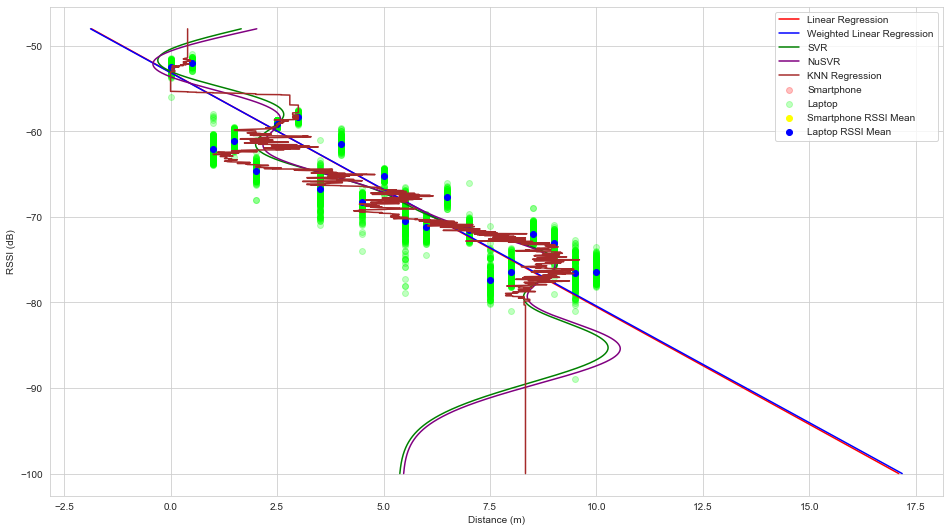

In [45]:
# Now let's plot the results
# Define the plot size
plt.figure(figsize=(16,9))

# The scatter plot for the data collected for the smartphone in transparent red
plt.scatter(y_smartphone, X_smartphone, c='#ff00003f', label='Smartphone')
# The scatter plot the data collected for the laptop transparent green
plt.scatter(y_laptop, X_laptop,c='#00ff003f', label='Laptop')

# Plot the points that mark the mean RSSI recorded by the smartphone for a given distance (yellow).
plt.scatter(data_plot_smartphone_means.distance,
            data_plot_smartphone_means.rssi,
            c='yellow', label='Smartphone RSSI Mean')
# Plot the points that mark the mean RSSI recorded by the laptop for a given distance (blue).
plt.scatter(data_plot_laptop_means.distance,
            data_plot_laptop_means.rssi,
            c='blue', label='Laptop RSSI Mean')

# Plot the prediction line for linear regression in red
plt.plot(linear_regression_predictions, X_, color='red', label='Linear Regression')
# Plot the prediction line for weighted linear regression in blue
plt.plot(weighted_linear_regression_predictions, X_, color='blue',label='Weighted Linear Regression')
# Plot the prediction curve for SVR in green
plt.plot(svr_predictions, X_, color='green', label='SVR')
# Plot the prediction curve for NuSVR in purple
plt.plot(nusvr_predictions, X_, color='purple', label='NuSVR')
plt.plot(knnr_predictions, X_, color='brown', label='KNN Regression')

# Set the X axis between the disance minimum -1 and the distance maximum +1 
#plt.xlim(y.min()-1, y.max()+1)
# Set the Y axis between the RSSI minimum -1 and the RSSI maximum +1 
#plt.ylim(X.min()-1, X.max()+1)

# Set the X axis ticks between the distance minimum -1 and the distance maximum +1 
#plt.xticks(np.arange(y.min(), y.max()+1, 1.0))
# Set the Y axis ticks between the RSSI minimum -1 and the RSSI maximum +1 
#plt.yticks(np.arange(X.min(), X.max()+1, 2.0))

# Set the X axis label
plt.xlabel('Distance (m)')
# Set the Y axis label
plt.ylabel('RSSI (dB)')

# Enable the grid
plt.grid(True)
# Show and place the legent
plt.legend(loc='upper right');

# Show the plot
plt.show()

### Cross Validated Predictions

In [48]:
# Now let's thake the best estimator that was found with GridSearchCV for each algorithm and put them to the test.
# These estimators should already be parametrized with the best parameters and we will retrain using cross validation
# just like before and perform predictions on the data that is kept for testing on each fold. We store the predicted
# distances and then store the difference to the real ones on a dedicate column in order to compute summarize statistics.

# Linear Regression
data['linear_regression_results'] = cross_val_predict(linear_regression_grid.best_estimator_, X, y,
                                                      # The split is the same we used previously for GridSearchCV 
                                                      cv=StratifiedKFold(n_splits=n_splits,
                                                                         shuffle=True,
                                                                         random_state=random_state).split(X, y_labels))
data['linear_regression_error'] = np.abs(data['linear_regression_results'] - data['distance'])

# Weighted Linear Regression
data['weighted_linear_regression_results'] = cross_val_predict(weighted_linear_regression_grid.best_estimator_, X, y,
                                                               # The split is the same we used previously for GridSearchCV 
                                                               cv=StratifiedKFold(n_splits=n_splits,
                                                                                  shuffle=True,
                                                                                  random_state=random_state).split(X, y_labels),
                                                                                  fit_params = { 'regression__sample_weight': X_weight })
data['weighted_linear_regression_error'] = np.abs(data['weighted_linear_regression_results'] - data['distance'])

# SVR
data['svr_results'] = cross_val_predict(svr_grid.best_estimator_, X, y.ravel(),
                                        cv=StratifiedKFold(n_splits=n_splits,
                                        shuffle=True, random_state=random_state).split(X, y_labels))
data['svr_error'] = np.abs(data['svr_results'] - data['distance'])

# NuSVR
data['nusvr_results'] = cross_val_predict(nusvr_grid.best_estimator_, X, y.ravel(),
                                        cv=StratifiedKFold(n_splits=n_splits,
                                        shuffle=True, random_state=random_state).split(X, y_labels))
data['nusvr_error'] = np.abs(data['nusvr_results'] - data['distance'])

# KNN Regression
data['knnr_results'] = cross_val_predict(knnr_grid.best_estimator_, X, y.ravel(),
                                        cv=StratifiedKFold(n_splits=n_splits,
                                        shuffle=True, random_state=random_state).split(X, y_labels))
data['knnr_error'] = np.abs(data['knnr_results'] - data['distance'])

# The error percentiles we are interested in
error_percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
# Show the distance error indicators
data[['linear_regression_error',
      'weighted_linear_regression_error',
      'svr_error',
      'nusvr_error',
      'knnr_error']].describe(error_percentiles)

,linear_regression_error,weighted_linear_regression_error,svr_error,nusvr_error,knnr_error
count,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000
mean,1.101975,1.102480,0.915392,0.921365,0.830188
std,0.653761,0.653202,0.588312,0.582111,0.648758
min,0.000486,0.000367,0.001077,0.000948,0.000000
25%,0.599902,0.598954,0.444510,0.458576,0.266667
50%,1.032125,1.037918,0.886879,0.920893,0.733333
75%,1.534657,1.530382,1.279068,1.287081,1.266667
90%,2.049803,2.051290,1.783315,1.742294,1.700000
95%,2.299244,2.302853,1.951777,1.838062,2.000000
99%,2.693736,2.700875,2.440671,2.480901,2.600000
